## 1-1. Data を読み込んでみよう

In [2]:
# Data を読み込む
import pandas as pd

df_info = pd.read_csv('accomodation_info.csv', index_col=0, parse_dates=[0])
df_info

,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:02:21,110034,若松 花子,B,19000
2018-11-01 00:03:10,112804,津田 美加子,D,20000
2018-11-01 00:06:19,110275,吉本 美加子,D,20000
2018-11-01 00:08:41,110169,坂本 直人,B,19000
2018-11-01 00:12:22,111504,青山 零,A,15000
...,...,...,...,...
2020-10-31 23:38:51,110049,吉本 篤司,A,3000
2020-10-31 23:42:12,110127,喜嶋 浩,A,3000
2020-10-31 23:47:24,115464,藤本 明美,D,8000


- 宿泊料金は、曜日や季節によって変動する。
    ※ コロナウイルス感染症の流行後は大幅な値下げを行なっている。
- Plan は４つあり、感染症流行前は、Restaurant での朝夕食付き Plan が人気だった。

| Plan | 内容          |
|------|-------------|
| A    | 素泊まり        |
| B    | 朝夕食付        |
| C    | 素泊まり露天風呂付客室 |
| D    | 朝夕食付露天風呂付客室 |

## 1-2. 時系列 Data を可視化してみよう
Data の大まかな全体像をつかむためと
- **「時間」**: 全体の数字が時間的にどのように変化しているか
- **「分布」**: 統計的にどのように分布しているか

という２つの軸で捉える。

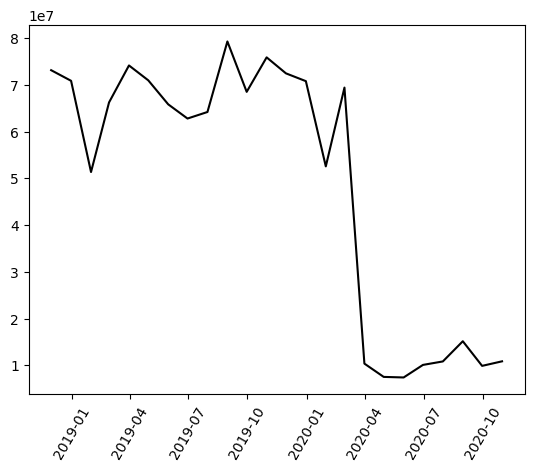

In [3]:
# 月ごとの売上を可視化する
import matplotlib.pyplot as plt
plt.plot(df_info['金額'].resample('M').sum(), color='k')
plt.xticks(rotation=60)
plt.show()

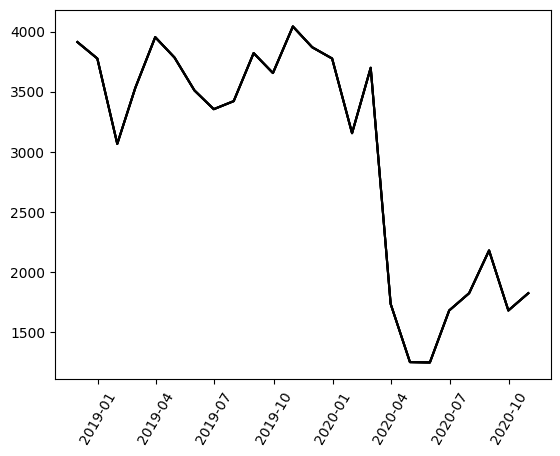

In [4]:
# 月ごとの利用者を可視化する
plt.plot(df_info.resample('M').count(), color='k')
plt.xticks(rotation=60)
plt.show()

売上も利用者も、感染症流行を経て激減している。

## 1-3. 平均値、中央値、最小値、最大値を出力してみよう
どのような利用者がいるのか全体像を把握するために、各利用者の統計値を確認する。

In [5]:
# 平均値、中央値、最小値、最大値の出力を行なう
x_mean = df_info['顧客ID'].value_counts().mean()
x_median = df_info['顧客ID'].value_counts().median()
x_min = df_info['顧客ID'].value_counts().min()
x_max = df_info['顧客ID'].value_counts().max()
print('平均値:', x_mean)
print('中央値:', x_median)
print('最小値:', x_min)
print('最大値:', x_max)

平均値: 13.073641997812613
中央値: 7.0
最小値: 1
最大値: 184


平均値が１３回なのに対して中央値が７回と大きく値がずれている。
利用者の利用回数が一様に分布していれば（利用回数が多い人も少ない人も、一様に存在すれば）平均値と中央値は概ね一致するので、利用回数の多少がまばらに分布しているなど、分布に偏りが見られると推測される。
実際に、最小値が１なのに対して最大値が 184, と最大値が平均値が遠い位置にあるため最小値に近い位置に利用回数が集中しており、最大値に近いところはまばらに点在しているのではないかと予想される。